In [1]:
import os
import sys
import time
import random
import numpy as np
import imgaug 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import zipfile
import urllib.request
import json
import shutil
from PIL import Image, ImageDraw

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../../Mask_RCNN/")
# Import Mask RCNN
# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
DEFAULT_DATASET_YEAR = "2019"

... done downloading pretrained model!


In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
############################################################
#  Configurations
############################################################

class SkinConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "skin"
    
    GPU_COUNT = 4
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + skin

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200
    
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 70
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # Skip detections with < 90% confidence
#     DETECTION_MIN_CONFIDENCE = 0.9
     # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
    
config = SkinConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      4
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [8]:
class SkinDataset(utils.Dataset):
    
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "skin"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
#             print(class_name)
    
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
#             print('hi')
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
#             print(image_id)
        
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
#             print(annotations)
            
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

## Creating Training and Validation Data

In [14]:
dataset_train = SkinDataset()
dataset_train.load_data('../../../Input/Skin_Datasets/Coco_format/train/instances_skin_train2019.json','../../../Input/Skin_Datasets/Coco_format/train/skin_train2019/')
dataset_train.prepare()

In [15]:
dataset_val = SkinDataset()
dataset_val.load_data('../../../Input/Skin_Datasets/Coco_format/val/instances_skin_val2019.json','../../../Input/Skin_Datasets/Coco_format/val/skin_val2019/')
dataset_val.prepare()

In [16]:
dataset_test = SkinDataset()
dataset_test.load_data('../../../Input/Skin_Datasets/Coco_format/test/instances_skin_test2019.json','../../../Input/Skin_Datasets/Coco_format/test/skin_test2019/')
dataset_test.prepare()

# Display a few images from the training dataset¶


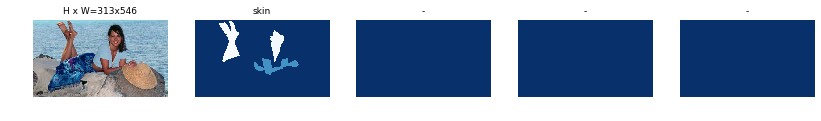

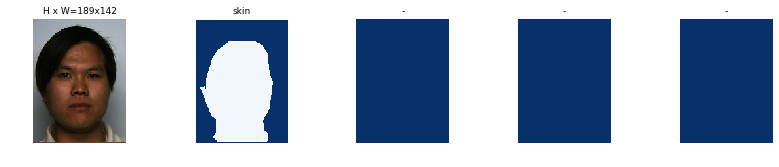

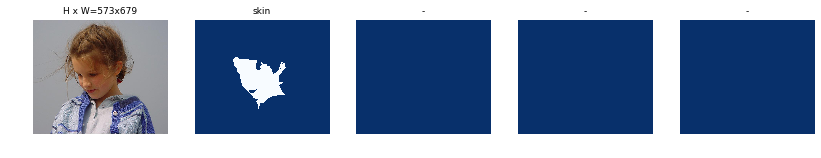

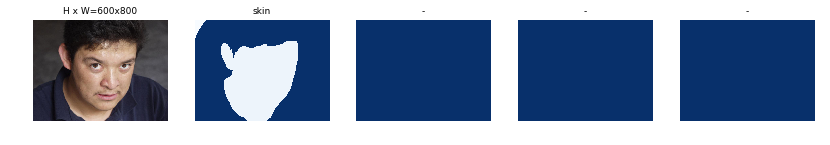

In [17]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train¶ 

In [11]:
# # Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)



Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# # Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

# Training
Train in two stages:

   * Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

   * Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.


In [13]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=8, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('Training took' + str(minutes)+ 'minutes')




Starting at epoch 0. LR=0.001

Checkpoint Path: /home/anirudh/anirudh_files/Umbilicus_Skin_Detection/Mask_RCNN/logs/skin20190430T1319/mask_rcnn_skin_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_con

/home/anirudh/.myenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/anirudh/.myenv/lib/python3.5/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/8
200/200 [==============================] - 573s 3s/step - loss: 3.6147 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 2.8137 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.3517 - val_loss: 3.1816 - val_rpn_class_loss: 0.0130 - val_rpn_bbox_loss: 2.2716 - val_mrcnn_class_loss: 0.1314 - val_mrcnn_bbox_loss: 0.4469 - val_mrcnn_mask_loss: 0.3187
Epoch 2/8
200/200 [==============================] - 291s 1s/step - loss: 2.7938 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 2.1096 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.2659 - mrcnn_mask_loss: 0.2608 - val_loss: 3.2984 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 2.5010 - val_mrcnn_class_loss: 0.1530 - val_mrcnn_bbox_loss: 0.3741 - val_mrcnn_mask_loss: 0.2538
Epoch 3/8
200/200 [==============================] - 311s 2s/step - loss: 1.9902 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 1.4479 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.2059 - val_loss: 3.6247 - val_rpn_class_loss

In [14]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=16, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('Training took' + str(minutes)+ 'minutes')




Starting at epoch 8. LR=0.0001

Checkpoint Path: /home/anirudh/anirudh_files/Umbilicus_Skin_Detection/Mask_RCNN/logs/skin20190430T1319/mask_rcnn_skin_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

# Prepare to run Inference 

In [18]:
class InferenceConfig(SkinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [19]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path = '/home/anirudh/Umbilicus_Skin_Detection/Mask_RCNN/logs/mask_rcnn_skin_0016.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/anirudh/Umbilicus_Skin_Detection/Mask_RCNN/logs/mask_rcnn_skin_0016.h5


# Run Inference

In [21]:
# Compute VOC-style Average Precision
# def compute_batch_ap(image_ids):
# image_ids = np.random.choice(dataset_val.image_ids, 28)
APs = []
accu=[]
c=0
negimages = []
ori=[]
pred=[]
for image_id in dataset_test.image_ids:
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    ## Visualizing results for each image
#     maskpre= visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#       
#     Counting Numper of Images where there are no predictions
    if (r['rois'].shape[0]==0):
        c= c+1
        negimages.append(image)
        continue
    maskpre=  r['masks'][:,:,0]
    acc = np.sum(gt_mask[:,:,0] == maskpre)/np.size(maskpre)
    print(acc)
    accu.append(acc)
    
    ori.append(image)
    pred.append(maskpre)
    
#     plt.close()
    
print("mean accu = "+str(np.mean(accu)))
    


0.9865264892578125
0.949275016784668
0.87939453125
0.9820060729980469
0.9685220718383789
0.8934259414672852
0.9103460311889648
0.925959587097168
0.9718093872070312
0.9592771530151367
0.9601097106933594
0.756291389465332
0.9721431732177734
0.9905605316162109
0.7690925598144531
0.9461536407470703
0.9466724395751953
0.9569025039672852
0.9903173446655273
0.9144783020019531
0.957305908203125
0.995391845703125
0.9859743118286133
0.9094209671020508
0.9537220001220703
0.9300603866577148
0.9843950271606445
0.9867305755615234
0.9769697189331055
0.9544000625610352
0.9918556213378906
0.9894800186157227
0.9868364334106445
0.9849348068237305
0.9965906143188477
0.6958990097045898
0.9702730178833008
0.9957895278930664
0.7455425262451172
0.8797769546508789
0.9092378616333008
0.9696407318115234
0.9695444107055664
0.9889450073242188
0.7075185775756836
0.9647626876831055
0.9874210357666016
0.9876842498779297
0.942784309387207
0.9695444107055664
0.9759120941162109
0.9645166397094727
0.9993000030517578
0.94

## Positive Predictions

In [26]:
import imshowpair
for i in range(0,266):
    imshowpair.imshowpair(ori[i],pred[i])
    plt.show()

ImportError: No module named 'imshowpair'

## No predictions

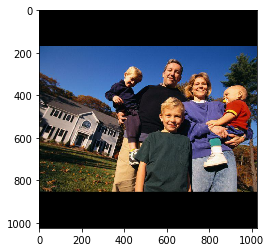

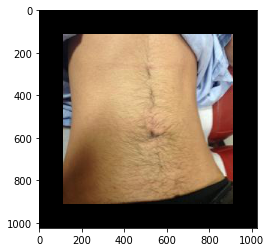

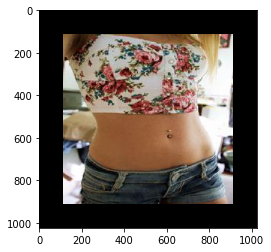

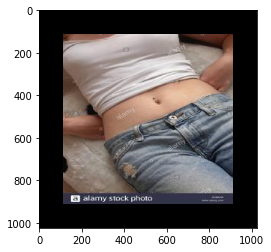

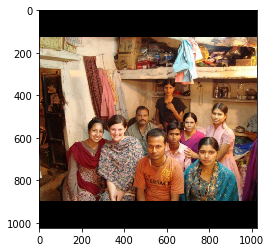

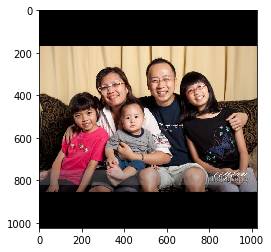

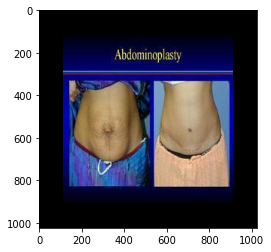

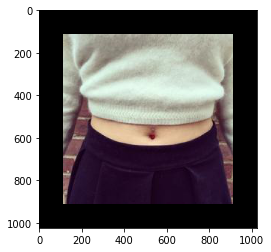

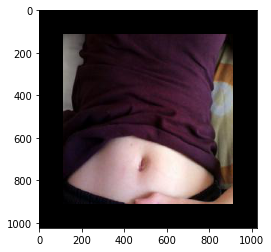

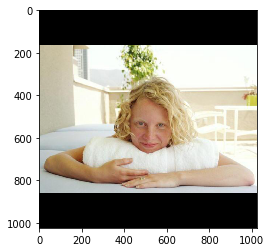

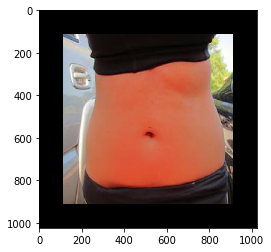

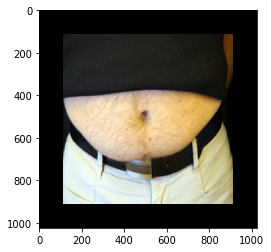

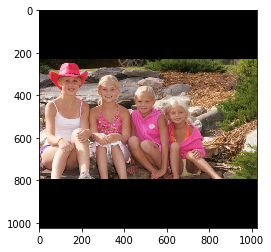

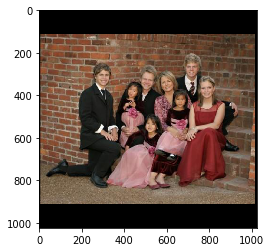

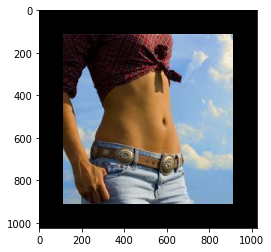

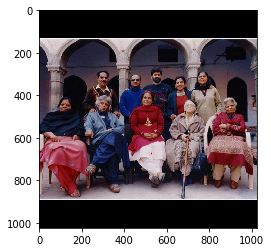

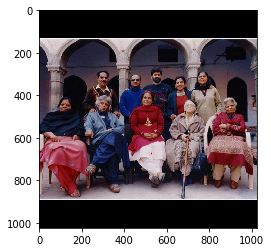

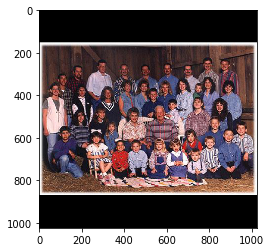

In [42]:
for i in range(0,c):
    plt.imshow(negimages[i])
    plt.show()